Missing values:
 AFP          0
AG           0
Age          0
ALB          0
ALP          0
ALT          0
AST          0
BASO#        0
BASO%        0
BUN          0
Ca           0
CA125        0
CA19-9       0
CA72-4       0
CEA          0
CL           0
CO2CP        0
CREA         0
DBIL         0
EO#          0
EO%          0
GGT          0
GLO          0
GLU.         0
HCT          0
HE4          0
HGB          0
IBIL         0
K            0
LYM#         0
LYM%         0
MCH          0
MCV          0
Menopause    0
Mg           0
MONO#        0
MONO%        0
MPV          0
Na           0
NEU          0
PCT          0
PDW          0
PHOS         0
PLT          0
RBC          0
RDW          0
TBIL         0
TP           0
UA           0
TYPE         0
dtype: int64


c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:19:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:19:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:19:50] WARNING: C:\actio


✅ Selected Features: ['Age', 'ALT', 'BASO#', 'BASO%', 'Ca', 'CA125', 'CA19-9', 'CL', 'CO2CP', 'CREA', 'EO#', 'EO%', 'GGT', 'GLO', 'HE4', 'LYM#', 'LYM%', 'Menopause', 'MONO#', 'MONO%', 'Na', 'NEU', 'PCT', 'PDW', 'PHOS', 'RBC', 'TP', 'UA']
Number of Features Selected: 28
Best Error (1 - CV accuracy): 0.07772108843537429
Final CV Accuracy: 0.9222789115646257
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


c:\Users\rahat\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:29:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}

✅ Test Accuracy with Tuned XGBoost Model: 0.8952380952380953

Confusion Matrix:
 [[45  6]
 [ 5 49]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        51
           1       0.89      0.91      0.90        54

    accuracy                           0.90       105
   macro avg       0.90      0.89      0.90       105
weighted avg       0.90      0.90      0.90       105



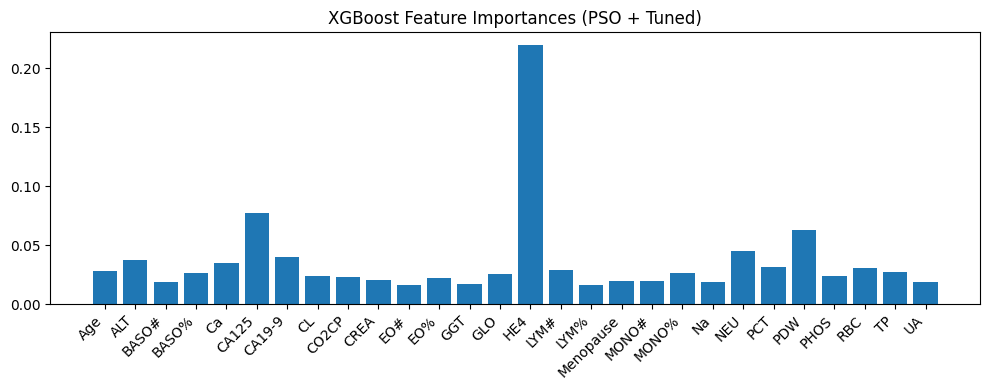

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from mealpy.swarm_based.PSO import OriginalPSO
import matplotlib.pyplot as plt

# 2. Load and Preprocess Data
data = pd.read_csv("../Datasets/ovariantotal.csv")
print("Missing values:\n", data.isnull().sum())
data = data.fillna(data.mean(numeric_only=True))

X = data.drop('TYPE', axis=1)
y = data['TYPE']

# 3. Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 5. Define PSO Fitness Function for Feature Selection
def feature_selection_fitness(solution):
    binary_solution = (np.array(solution) > 0.5).astype(int)
    if np.sum(binary_solution) == 0:
        return 1.0  # Worst case

    selected_X = X_train[:, binary_solution == 1]

    model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1
    )

    scores = cross_val_score(model, selected_X, y_train, cv=5, scoring='accuracy')
    return 1 - np.mean(scores)

# 6. Setup PSO Problem
problem = {
    "fit_func": feature_selection_fitness,
    "lb": [0] * X_train.shape[1],
    "ub": [1] * X_train.shape[1],
    "minmax": "min",
    "log_to": None
}

# 7. Run PSO
pso_model = OriginalPSO(epoch=50, pop_size=20, c1=2.0, c2=2.0, w_min=0.4, w_max=0.9)
best_position, best_fitness = pso_model.solve(problem)

# 8. Extract Selected Features
selected_features = (np.array(best_position) > 0.5).astype(int)
selected_indices = np.where(selected_features == 1)[0]
selected_feature_names = X.columns[selected_indices]

print("\n✅ Selected Features:", list(selected_feature_names))
print("Number of Features Selected:", len(selected_feature_names))
print("Best Error (1 - CV accuracy):", best_fitness)
print("Final CV Accuracy:", 1 - best_fitness)

# 9. Prepare Selected Features for Train/Test
X_train_selected = X_train[:, selected_features == 1]
X_test_selected = X_test[:, selected_features == 1]

# 10. Define Hyperparameter Grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5],
    'min_child_weight': [1, 3, 5]
}

# 11. Base Model
xgb_base = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# 12. Run Grid Search
grid_search = GridSearchCV(estimator=xgb_base,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_selected, y_train)

# 13. Evaluate Best Model
best_model = grid_search.best_estimator_
print("\n✅ Best Hyperparameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)

print("\n✅ Test Accuracy with Tuned XGBoost Model:", test_accuracy)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 14. Feature Importance Plot
importances = best_model.feature_importances_
plt.figure(figsize=(10, 4))
plt.bar(selected_feature_names, importances)
plt.xticks(rotation=45, ha="right")
plt.title("XGBoost Feature Importances (PSO + Tuned)")
plt.tight_layout()
plt.show()
